# Gradient Boosting Trees

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
from constants import *

TARGET_FUT, INTERVAL

('ZC', '15m')

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

./data/\futures_15m.csv
(4224, 144)
Index(['10Y_Open', '10Y_High', '10Y_Low', '10Y_Close', '10Y_Volume',
       '10Y_Spread', 'CL_Open', 'CL_High', 'CL_Low', 'CL_Close',
       ...
       'ZW_Low', 'ZW_Close', 'ZW_Volume', 'ZW_Spread', '^VIX_Open',
       '^VIX_High', '^VIX_Low', '^VIX_Close', '^VIX_Volume', '^VIX_Spread'],
      dtype='object', length=144)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Spread,CL_Open,CL_High,CL_Low,CL_Close,...,ZW_Low,ZW_Close,ZW_Volume,ZW_Spread,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Close,^VIX_Volume,^VIX_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-24 22:16:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,555.75,556.25,494,4.25,13.67,13.67,13.65,13.65,0.0,0.02
2024-03-24 22:31:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,555.75,556.25,494,4.25,13.67,13.67,13.65,13.65,0.0,0.02


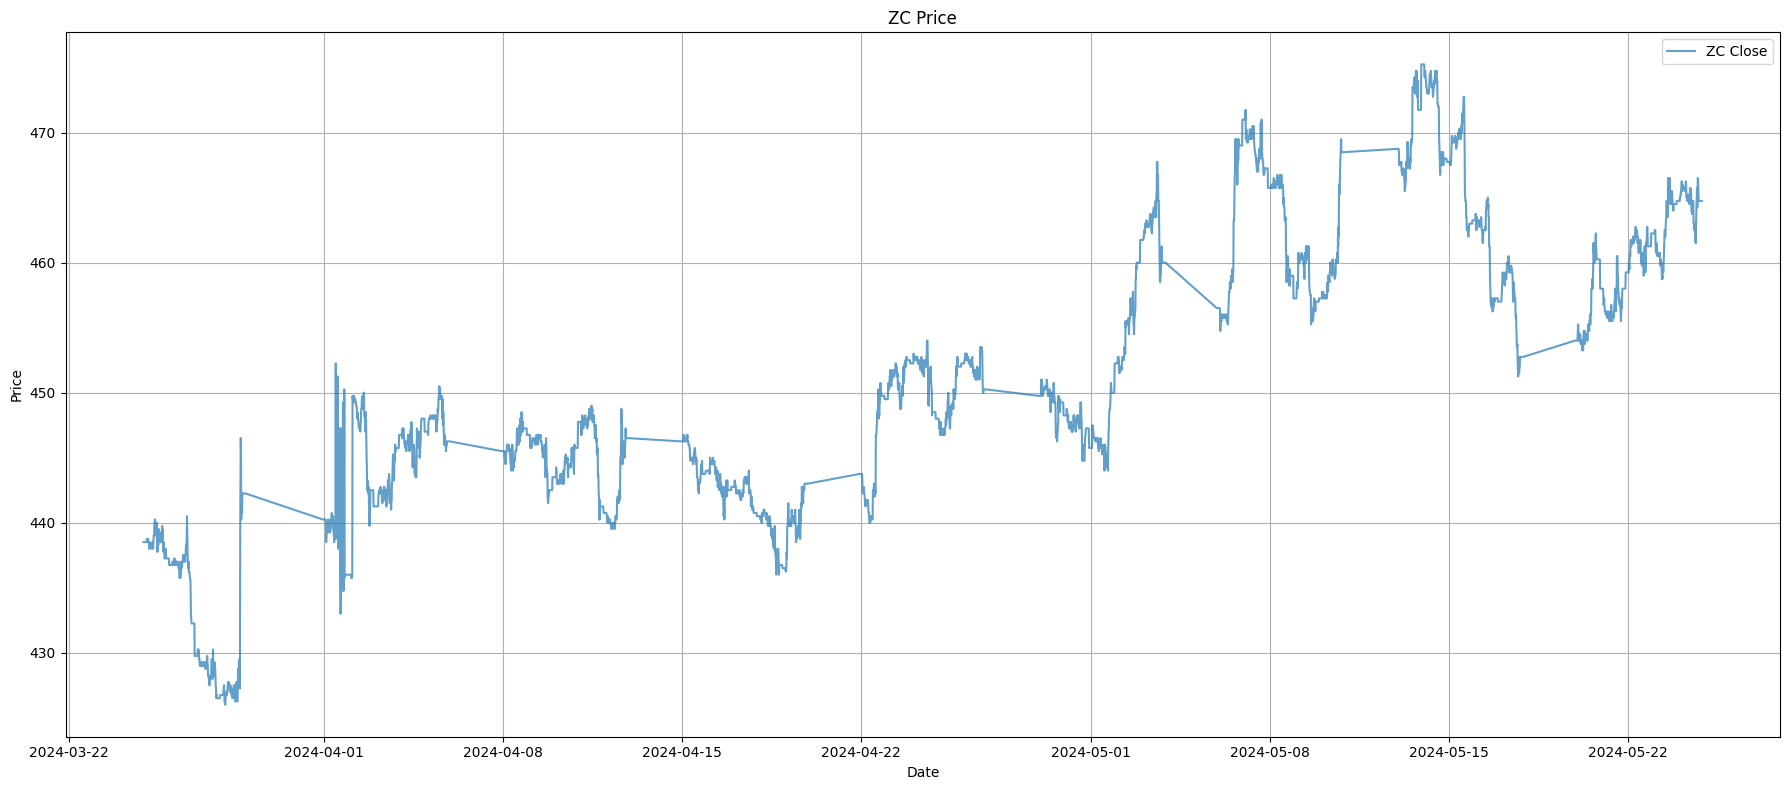

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
target_fut_df = futs_df[
    [item for f in MARKET_FUTS + AGRI_FUTS for item in [f"{f.replace('=F', '')}_Close", f"{f.replace('=F', '')}_High", f"{f.replace('=F', '')}_Low", f"{f.replace('=F', '')}_Open", f"{f.replace('=F', '')}_Volume"]]
]

target_fut_df.tail(5)

,ES_Close,ES_High,ES_Low,ES_Open,ES_Volume,NQ_Close,NQ_High,NQ_Low,NQ_Open,NQ_Volume,...,GF_Close,GF_High,GF_Low,GF_Open,GF_Volume,DC_Close,DC_High,DC_Low,DC_Open,DC_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-24 21:01:00+00:00,5325.25,5327.75,5321.75,5322.0,24282.0,18915.25,18923.25,18900.0,18903.25,11006.0,...,260.424988,260.424988,260.075012,260.125,209,19.889999,19.969999,18.57,19.969999,151
2024-05-24 21:16:00+00:00,5325.25,5327.75,5321.75,5322.0,24282.0,18915.25,18923.25,18900.0,18903.25,11006.0,...,260.424988,260.424988,260.075012,260.125,209,19.889999,19.969999,18.57,19.969999,151
2024-05-24 21:31:00+00:00,5325.25,5327.75,5321.75,5322.0,24282.0,18915.25,18923.25,18900.0,18903.25,11006.0,...,260.424988,260.424988,260.075012,260.125,209,19.889999,19.969999,18.57,19.969999,151
2024-05-24 21:46:00+00:00,5325.25,5327.75,5321.75,5322.0,24282.0,18915.25,18923.25,18900.0,18903.25,11006.0,...,260.424988,260.424988,260.075012,260.125,209,19.889999,19.969999,18.57,19.969999,151
2024-05-24 22:00:00+00:00,5325.25,5327.75,5321.75,5322.0,24282.0,18915.25,18923.25,18900.0,18903.25,11006.0,...,260.424988,260.424988,260.075012,260.125,209,19.889999,19.969999,18.57,19.969999,151


# Prepare the Data

In [7]:
from signals import dynamic_support_resistance, kalman_backtest, signal_kf_bollinger_bands
from quant_equations import get_ou, modulate_std

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")

window = abs(HALF_LIFE)
bb_df = signal_kf_bollinger_bands(target_fut_df, f"{TARGET_FUT}_Close", f"{TARGET_FUT}_Volume", std_factor=modulate_std(HURST))

spread = bb_df["%B"].bfill().ffill()
volumes = target_fut_df[f"{TARGET_FUT}_Volume"].to_numpy()
prices = target_fut_df[f"{TARGET_FUT}_Close"].to_numpy()

assert not np.isnan(spread).any() and not np.isnan(volumes).any()

big_fut_df, _, _ = dynamic_support_resistance(futs_df, f"{TARGET_FUT}_Close", f"{TARGET_FUT}_High",f"{TARGET_FUT}_Low",window_size=HALF_LIFE)
kf_df, _ = kalman_backtest(spread, volumes, prices, period=INTERVAL)

big_fut_df = pd.concat([big_fut_df, kf_df], axis=1).bfill().ffill()
big_fut_df

100%|██████████| 3802/3802 [00:01<00:00, 2421.69it/s]
kalman_backtest: 3802it [00:00, 8029.55it/s]


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Spread,CL_Open,CL_High,CL_Low,CL_Close,...,KG_Z2,SB,SS,SBS,SSB,Closed,Position,Ret,cRets,Drawdown
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-24 22:16:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,0.023625,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2024-03-24 22:31:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,0.023625,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2024-03-24 22:46:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,0.023625,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2024-03-24 23:01:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,0.023625,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2024-03-24 23:16:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.709999,80.769997,80.680000,80.760002,...,0.023625,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24 21:01:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.139981,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.251642,-0.097866
2024-05-24 21:16:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.143351,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.251642,-0.097866
2024-05-24 21:31:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.146502,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.251642,-0.097866


In [8]:
import pandas as pd
from tqdm import tqdm

META_LABEL = "profit_label"

big_fut_df[META_LABEL] = 0
position = 0
start_index = None
entry_price = 0

for i, row in tqdm(big_fut_df.iterrows(), desc="Posthoc Metalabeling"):
    if row['Closed'] != 0:
        # Position closed, work backwards
        ret = row['Ret']
        metalabel = 1 if ret > 0 else -1
        if start_index is not None:
            big_fut_df.loc[start_index:row.name, META_LABEL] = metalabel

        position = 0
        start_index = None
        entry_price = 0

    if row['Position'] != 0 and position == 0:
        # New position opened
        position = row['Position']
        start_index = row.name
        entry_price = row[f"{TARGET_FUT}_Close"]

metalabel_df = big_fut_df[[f"{TARGET_FUT}_Close", 'Position', "Ret", 'Z1', 'Z2', 'X', META_LABEL]]
metalabel_df[metalabel_df[META_LABEL] != 0]

Posthoc Metalabeling: 4224it [00:00, 48689.62it/s]


,ZC_Close,Position,Ret,Z1,Z2,X,profit_label
Date,,,,,,,
2024-04-01 09:01:00+00:00,439.00,1.0,0.00000,-0.174053,-0.026270,0.063690,1
2024-04-01 09:16:00+00:00,438.50,1.0,0.00000,-0.138205,-0.014129,0.045236,1
2024-04-01 09:31:00+00:00,439.25,1.0,0.00000,0.051709,0.024247,0.519308,1
2024-04-01 09:46:00+00:00,439.50,1.0,0.00000,0.122125,0.033362,0.606480,1
2024-04-01 10:01:00+00:00,439.00,1.0,0.00000,0.080326,0.018540,0.351871,1
...,...,...,...,...,...,...,...
2024-05-24 15:46:00+00:00,462.25,1.0,0.00000,0.000369,0.013002,-0.038095,1
2024-05-24 16:01:00+00:00,461.50,1.0,0.00000,-0.031775,-0.000151,-0.194483,1
2024-05-24 16:16:00+00:00,462.75,1.0,0.00000,0.161042,0.057614,0.148852,1


# GBC

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


big_fut_df[META_LABEL] = big_fut_df[META_LABEL] > 0  # Set to binary (lose = 0, win = 1)
X = big_fut_df.drop(columns=[META_LABEL])
y = big_fut_df[META_LABEL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='precision', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best precision score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
best_model

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best precision score: 1.0


GradientBoostingClassifier(learning_rate=0.01, random_state=42)

              precision    recall  f1-score   support

       False       0.89      1.00      0.94       742
        True       1.00      0.14      0.24       103

    accuracy                           0.89       845
   macro avg       0.95      0.57      0.59       845
weighted avg       0.91      0.89      0.86       845



<Figure size 640x480 with 0 Axes>

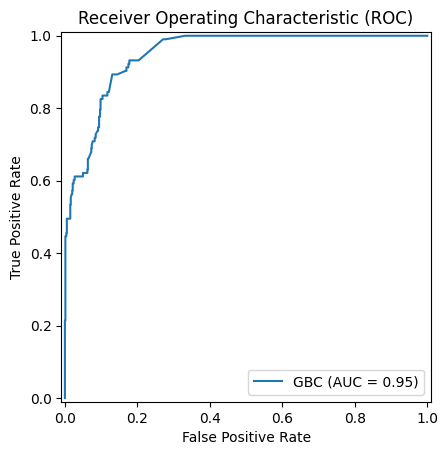

<Figure size 640x480 with 0 Axes>

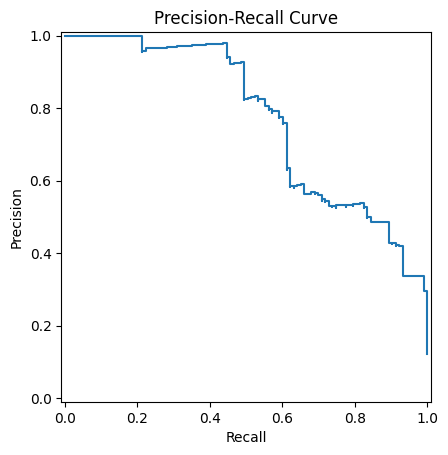

Precision: 1.0000
Recall: 0.1359
F1 Beta Score: 0.9060


In [21]:
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, fbeta_score, precision_score, recall_score, RocCurveDisplay, PrecisionRecallDisplay

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="GBC").plot()
plt.title('Receiver Operating Characteristic (ROC)')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title('Precision-Recall Curve')
plt.show()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = fbeta_score(y_test, y_pred, average='weighted', beta=0.)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Beta Score: {f1:.4f}')

## XAI

The summary plot provides a global view of feature importance across all predictions. The SHAP value represents the impact of each feature on the model's output. 

Positive SHAP values push the prediction towards one class (mean reversion in your case), while negative SHAP values push it towards the other class (random walk).

The magnitude of the SHAP value indicates the strength of the impact. Larger absolute values mean a stronger impact on the prediction.

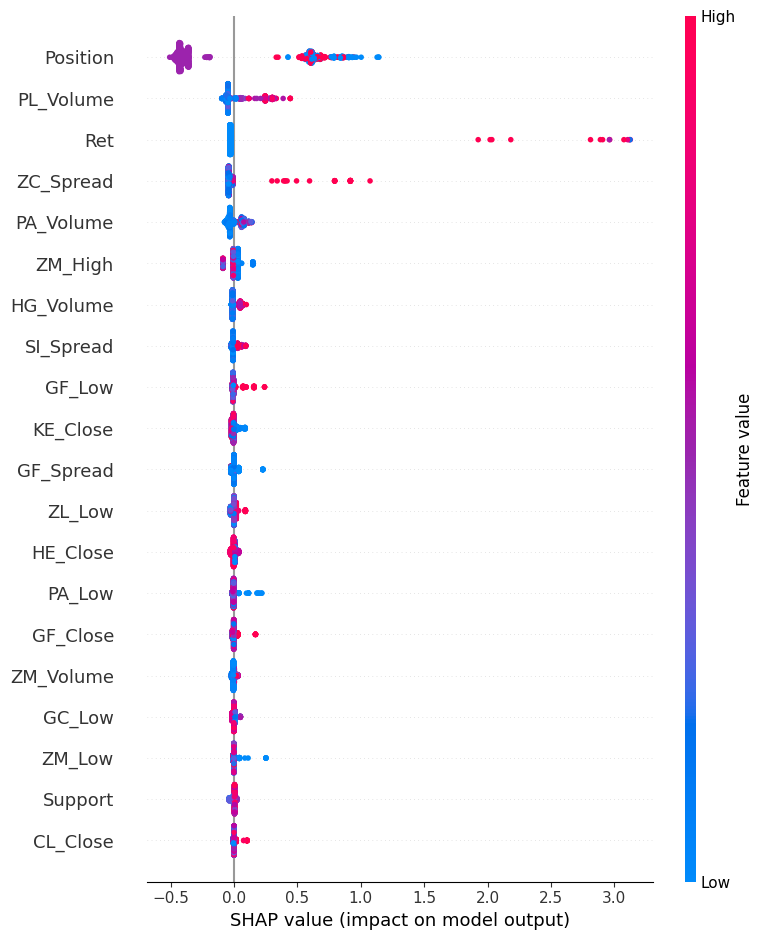

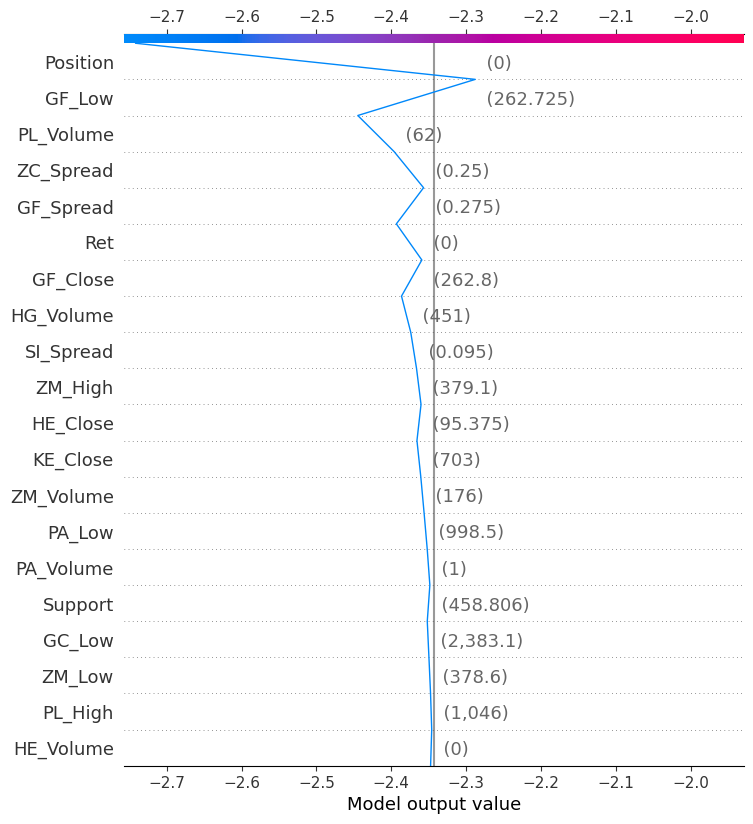

In [23]:
import shap

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
shap.decision_plot(explainer.expected_value, shap_values.values[0], X_test.iloc[0])